In [1]:
import sys
sys.path.append('d:/flagellar/code/core')
sys.path.append('/flagellar/code/core/')
sys.path.append('/kaggle/input/my-flagellar-library/')
import flg_support as fls
import flg_runner
import importlib
import numpy as np
import matplotlib.pyplot as plt
import time
import copy
import os
import itertools
import glob
import dataclasses
import pandas as pd
import statsmodels.api as sm
import ISLP
import ISLP.models
import subprocess
import io

MainProcess


In [2]:
# Prepare datasets
fls.download_kaggle_dataset('jeroencottaar/byu-many-models-abbreviated/', fls.result_dir + '/many_abbr_res/')

In [3]:
# Read results from vast.ai
files = glob.glob(fls.result_dir + '/many_abbr_res/' + '*.pickle')
dicts = []
dicts_kaggle_comp = []
for f in files:    
    print(f)
    data = fls.dill_load(f)    
    d = data.modifier_values
    d['label'] = data.label
    d['git_commit_id'] = data.git_commit_id
    d['use_missing_value'] = data.use_missing_value
    d['cv_score'] = fls.score_competition_metric(data.inferred_test_data, data.test_data)[2]

    d_kaggle_comp = dict()
    d_kaggle_comp['label'] = data.label
    d_kaggle_comp['git_commit_id'] = d['git_commit_id']
    d_kaggle_comp['use_missing_value'] = d['use_missing_value']
    d_kaggle_comp['seed'] = d['seed']   
    d_kaggle_comp['cv_score'] = d['cv_score']
    d_kaggle_comp['k_score'] = np.nan

    dicts_kaggle_comp.append(d_kaggle_comp)

    # First set
    #if not (d['seed']<26 or d['use_missing_value']): print('skip'); continue

    # New
    #if not (d['seed']>=26 or d['use_missing_value']): print('skip'); continue
    #if d['label']=='Test ensemble': continue
    
    for partial in fls.DataSelector().datasets:
        data_selector = fls.DataSelector()
        data_selector.datasets = [partial]
        d['cv_score_' + partial] = fls.score_competition_metric(data_selector.select(data.inferred_test_data), data_selector.select(data.test_data))[2]
    d['k_score']= np.nan

    dicts.append(d)    
p = pd.DataFrame(dicts)
p.sort_values(['seed', 'git_commit_id'], inplace=True);

p_kaggle_comp = pd.DataFrame(dicts_kaggle_comp)
p_kaggle_comp.sort_values(['seed', 'git_commit_id'], inplace=True);

# First set
# p = p[np.logical_or(p['seed']<26, p['use_missing_value'])]

# New
#p = p[np.logical_or(p['seed']>=26, p['use_missing_value'])]

p = p.reset_index()
p_kaggle_comp = p_kaggle_comp.reset_index()

d:/flagellar/results//many_abbr_res\Baseline_0_d7f7501f_.81 _a.pickle
d:/flagellar/results//many_abbr_res\Baseline_1_d7f7501f_.86 _a.pickle
d:/flagellar/results//many_abbr_res\Baseline_2_d7f7501f_.89 _a.pickle
d:/flagellar/results//many_abbr_res\Baseline_3_d7f7501f_.85 _a.pickle


In [4]:
# Load Kaggle results
p_kaggle_results = pd.read_csv(fls.code_dir + '../kaggle_results.csv').reset_index()

In [5]:
# Add competition results
csv = subprocess.run('kaggle competitions submissions -q -csv -c byu-locating-bacterial-flagellar-motors-2025', encoding = 'utf-8', shell=True, stdout=subprocess.PIPE)
lines = csv.stdout.split('\n')[1:]
data_str = "\n".join(lines)
p_submissions = pd.read_fwf(io.StringIO(data_str), skiprows=[1])
for i_i in range(len(p_kaggle_results)):
    mv_str = 'Ma' if p_kaggle_results.loc[i_i, 'use_missing_value'] else ''
    name_str = p_kaggle_results.loc[i_i, 'label'] + '_' + str(p_kaggle_results.loc[i_i, 'seed']) + mv_str + '_' + p_kaggle_results.loc[i_i, 'git_commit_id'][:8]
    for i_k in range(len(p_submissions)):
        if name_str == p_submissions.loc[i_k, 'description']:
            score = p_submissions.loc[i_k, 'publicScore']
            if not np.isnan(score):
                if np.isnan(p_kaggle_results.loc[i_i, 'k_score']):
                    p_kaggle_results.loc[i_i, 'k_score'] = score
                    print(f'Added score of {score:1.3} for {name_str}')
                else:
                    if not score == p_kaggle_results.loc[i_i, 'k_score']:
                        raise Exception(f'Mismatch for {name_str}: {score:1.3} vs {p_kaggle_results.loc[i_i, "k_score"]:1.3}')
            else:
                print('NaN score found for ', name_str)            
            break

In [6]:
#print(p_kaggle_results)
for i_k in range(len(p_kaggle_results)):
    for i_i in range(len(p_kaggle_comp)):
        if p_kaggle_results['seed'][i_k] == p_kaggle_comp['seed'][i_i] and p_kaggle_results['git_commit_id'][i_k] == p_kaggle_comp['git_commit_id'][i_i] and  p_kaggle_results['use_missing_value'][i_k] == p_kaggle_comp['use_missing_value'][i_i] and  p_kaggle_results['label'][i_k] == p_kaggle_comp['label'][i_i]:
            p_kaggle_comp.loc[i_i,'k_score'] = p_kaggle_results['k_score'][i_k]
for i_k in range(len(p_kaggle_results)):
    for i_i in range(len(p)):
        if p_kaggle_results['seed'][i_k] == p['seed'][i_i] and p_kaggle_results['git_commit_id'][i_k] == p['git_commit_id'][i_i] and  p_kaggle_results['use_missing_value'][i_k] == p['use_missing_value'][i_i] and  p_kaggle_results['label'][i_k] == p['label'][i_i]:
            p.loc[i_i,'k_score'] = p_kaggle_results['k_score'][i_k]

In [7]:
# Write results to Kaggle results file
p_kaggle_cache = copy.deepcopy(p_kaggle_comp[['label', 'git_commit_id', 'use_missing_value', 'seed', 'cv_score', 'k_score']])
p_kaggle_cache.to_csv(fls.code_dir + '../kaggle_results.csv')

In [8]:
p.to_csv(fls.code_dir + '../results.csv')
p

,index,seed,n_ensemble,scale_percentile_value,img_size,n_epochs,model_name,use_pretrained_weights,box_size,trust,...,ycw,label,git_commit_id,use_missing_value,cv_score,cv_score_tom,cv_score_ycw,cv_score_aba,cv_score_mba,k_score
0,0,0,4,3.547847,768,29,yolov8m,False,20,3,...,False,Baseline,d7f7501f42e9da63414ec71ae3a608ff429ee1ab,False,0.497804,0.901163,0.698925,0.575221,0.186441,0.505
1,1,1,4,3.047286,832,40,yolov8m,True,21,3,...,True,Baseline,d7f7501f42e9da63414ec71ae3a608ff429ee1ab,False,0.555556,0.892857,0.833333,0.738636,0.210793,0.410
2,2,2,4,2.046449,576,29,yolov8m,False,26,4,...,False,Baseline,d7f7501f42e9da63414ec71ae3a608ff429ee1ab,False,0.791638,0.906433,0.833333,0.639535,0.805022,NaN
3,3,3,4,1.342597,640,28,yolov8m,True,26,3,...,True,Baseline,d7f7501f42e9da63414ec71ae3a608ff429ee1ab,False,0.604868,0.894428,0.833333,0.856354,0.250836,NaN


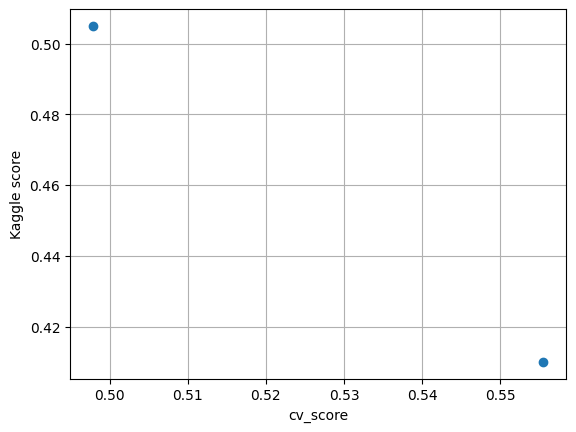

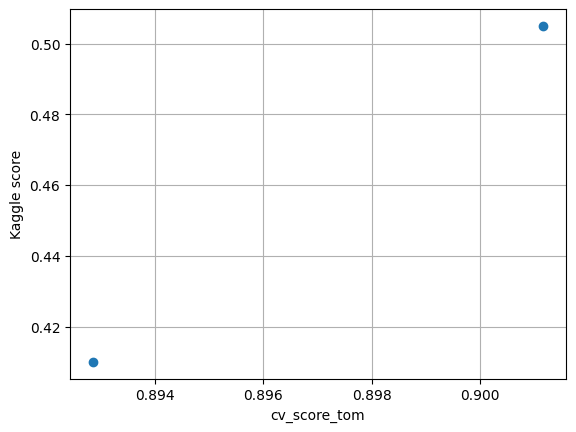

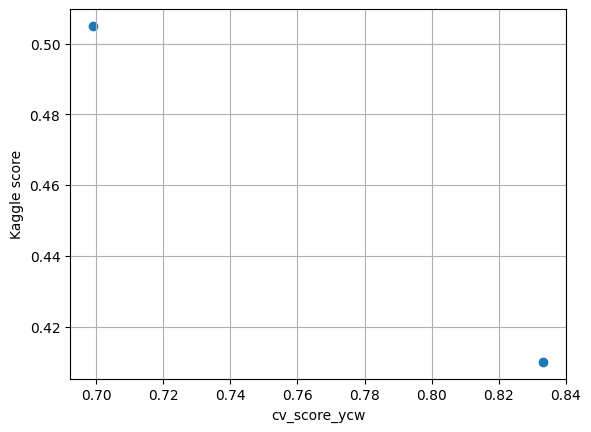

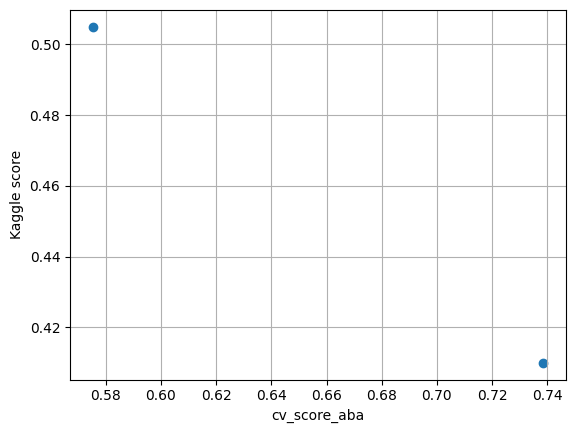

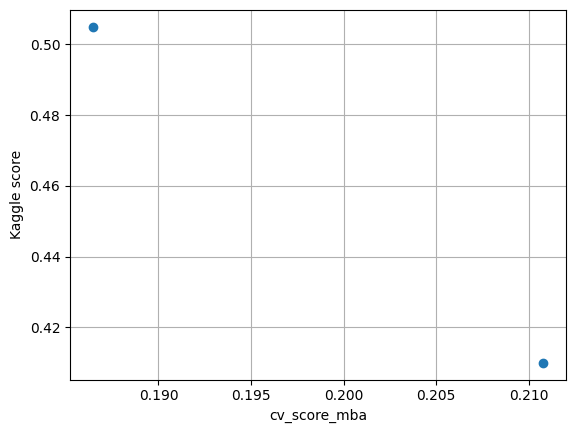

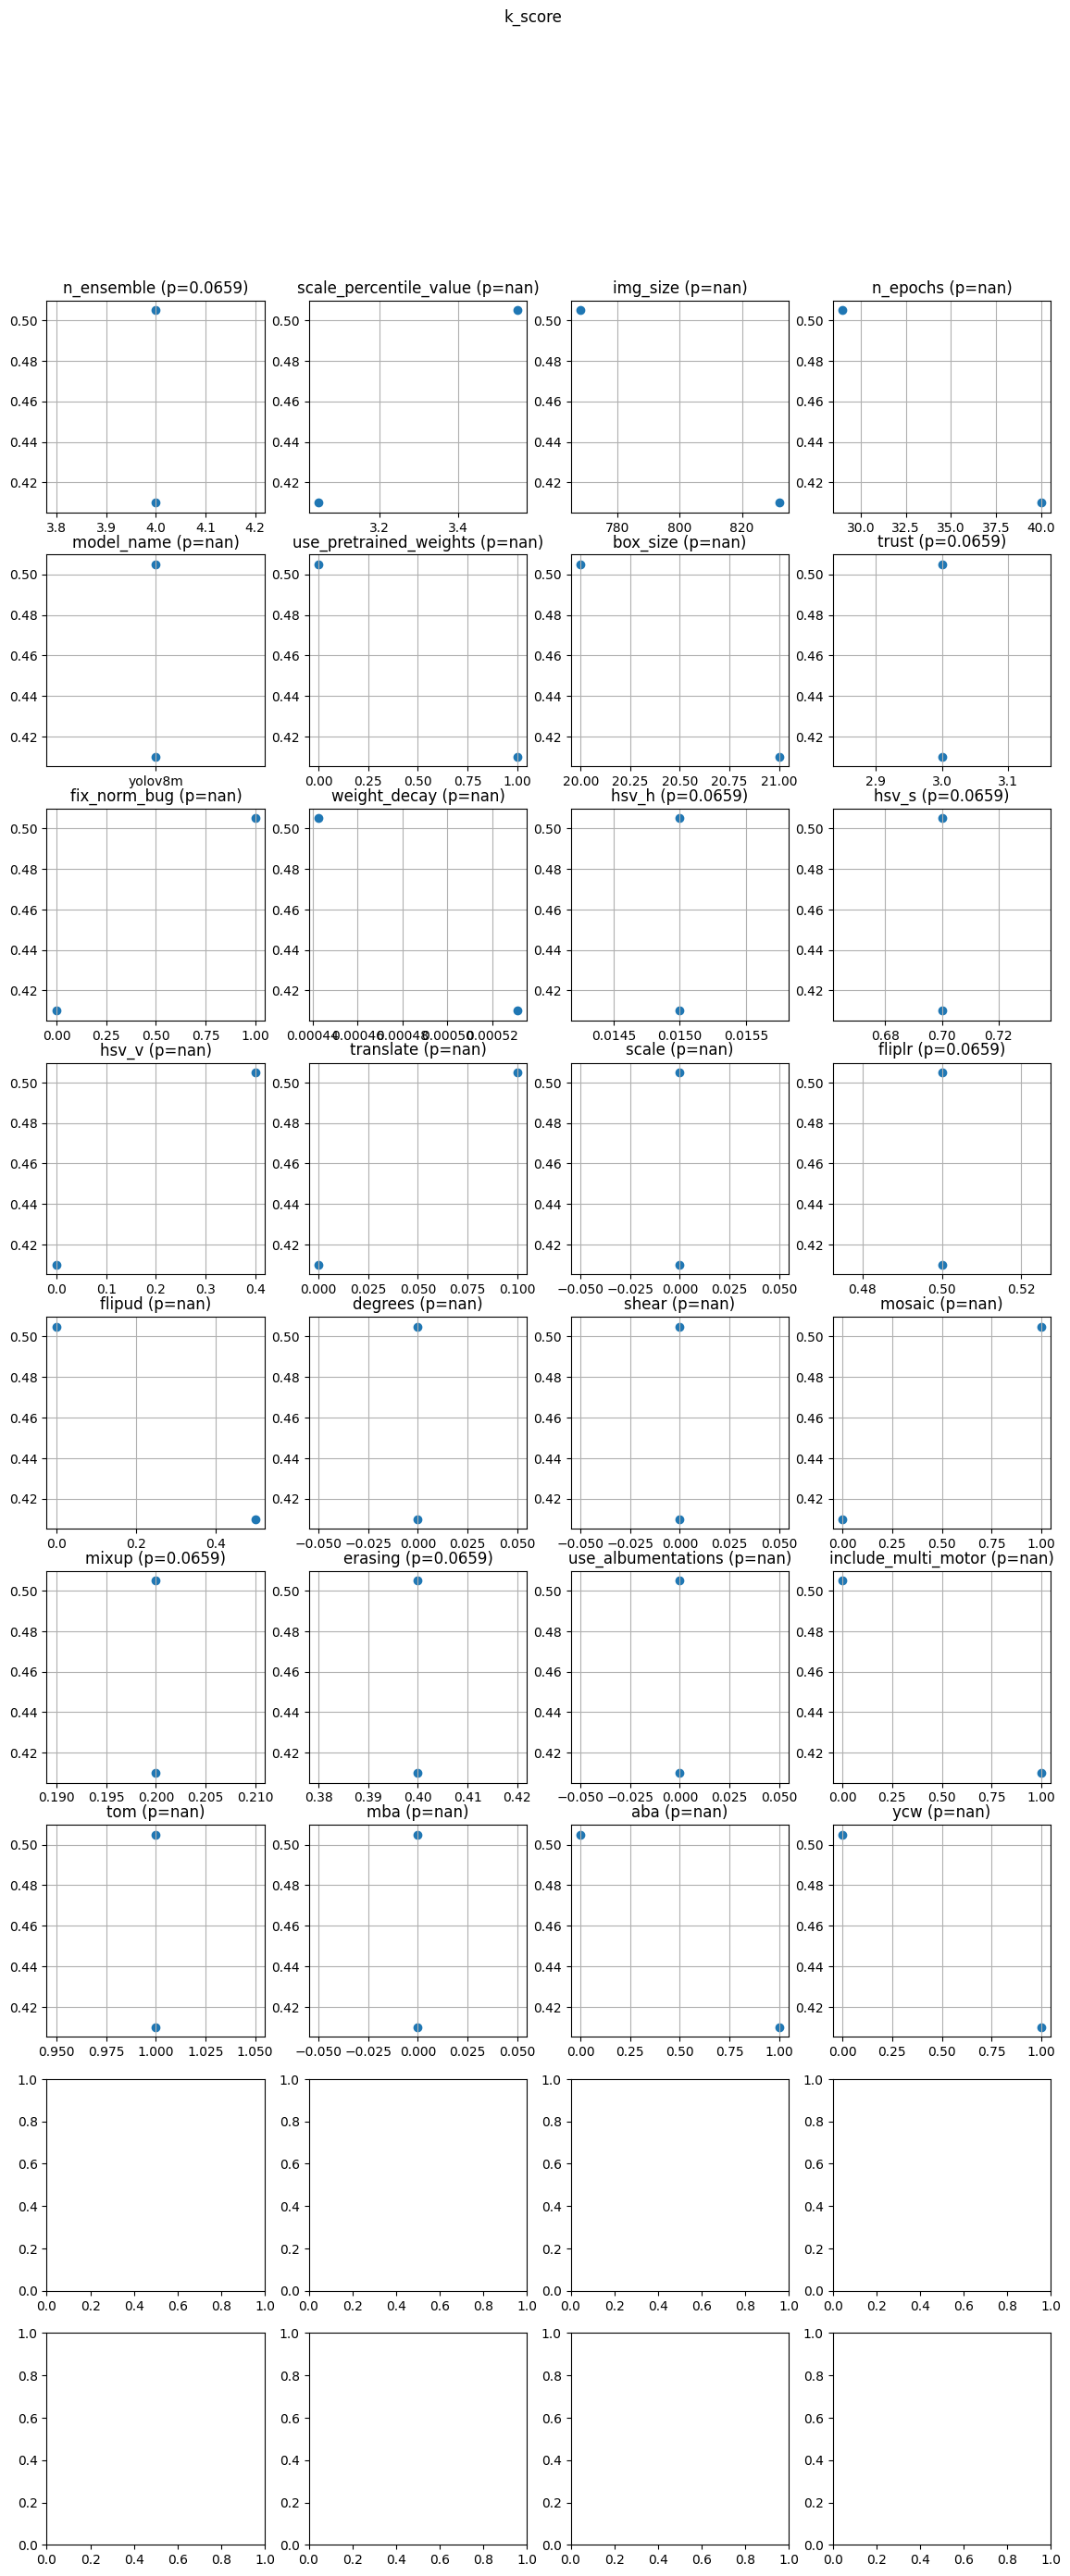

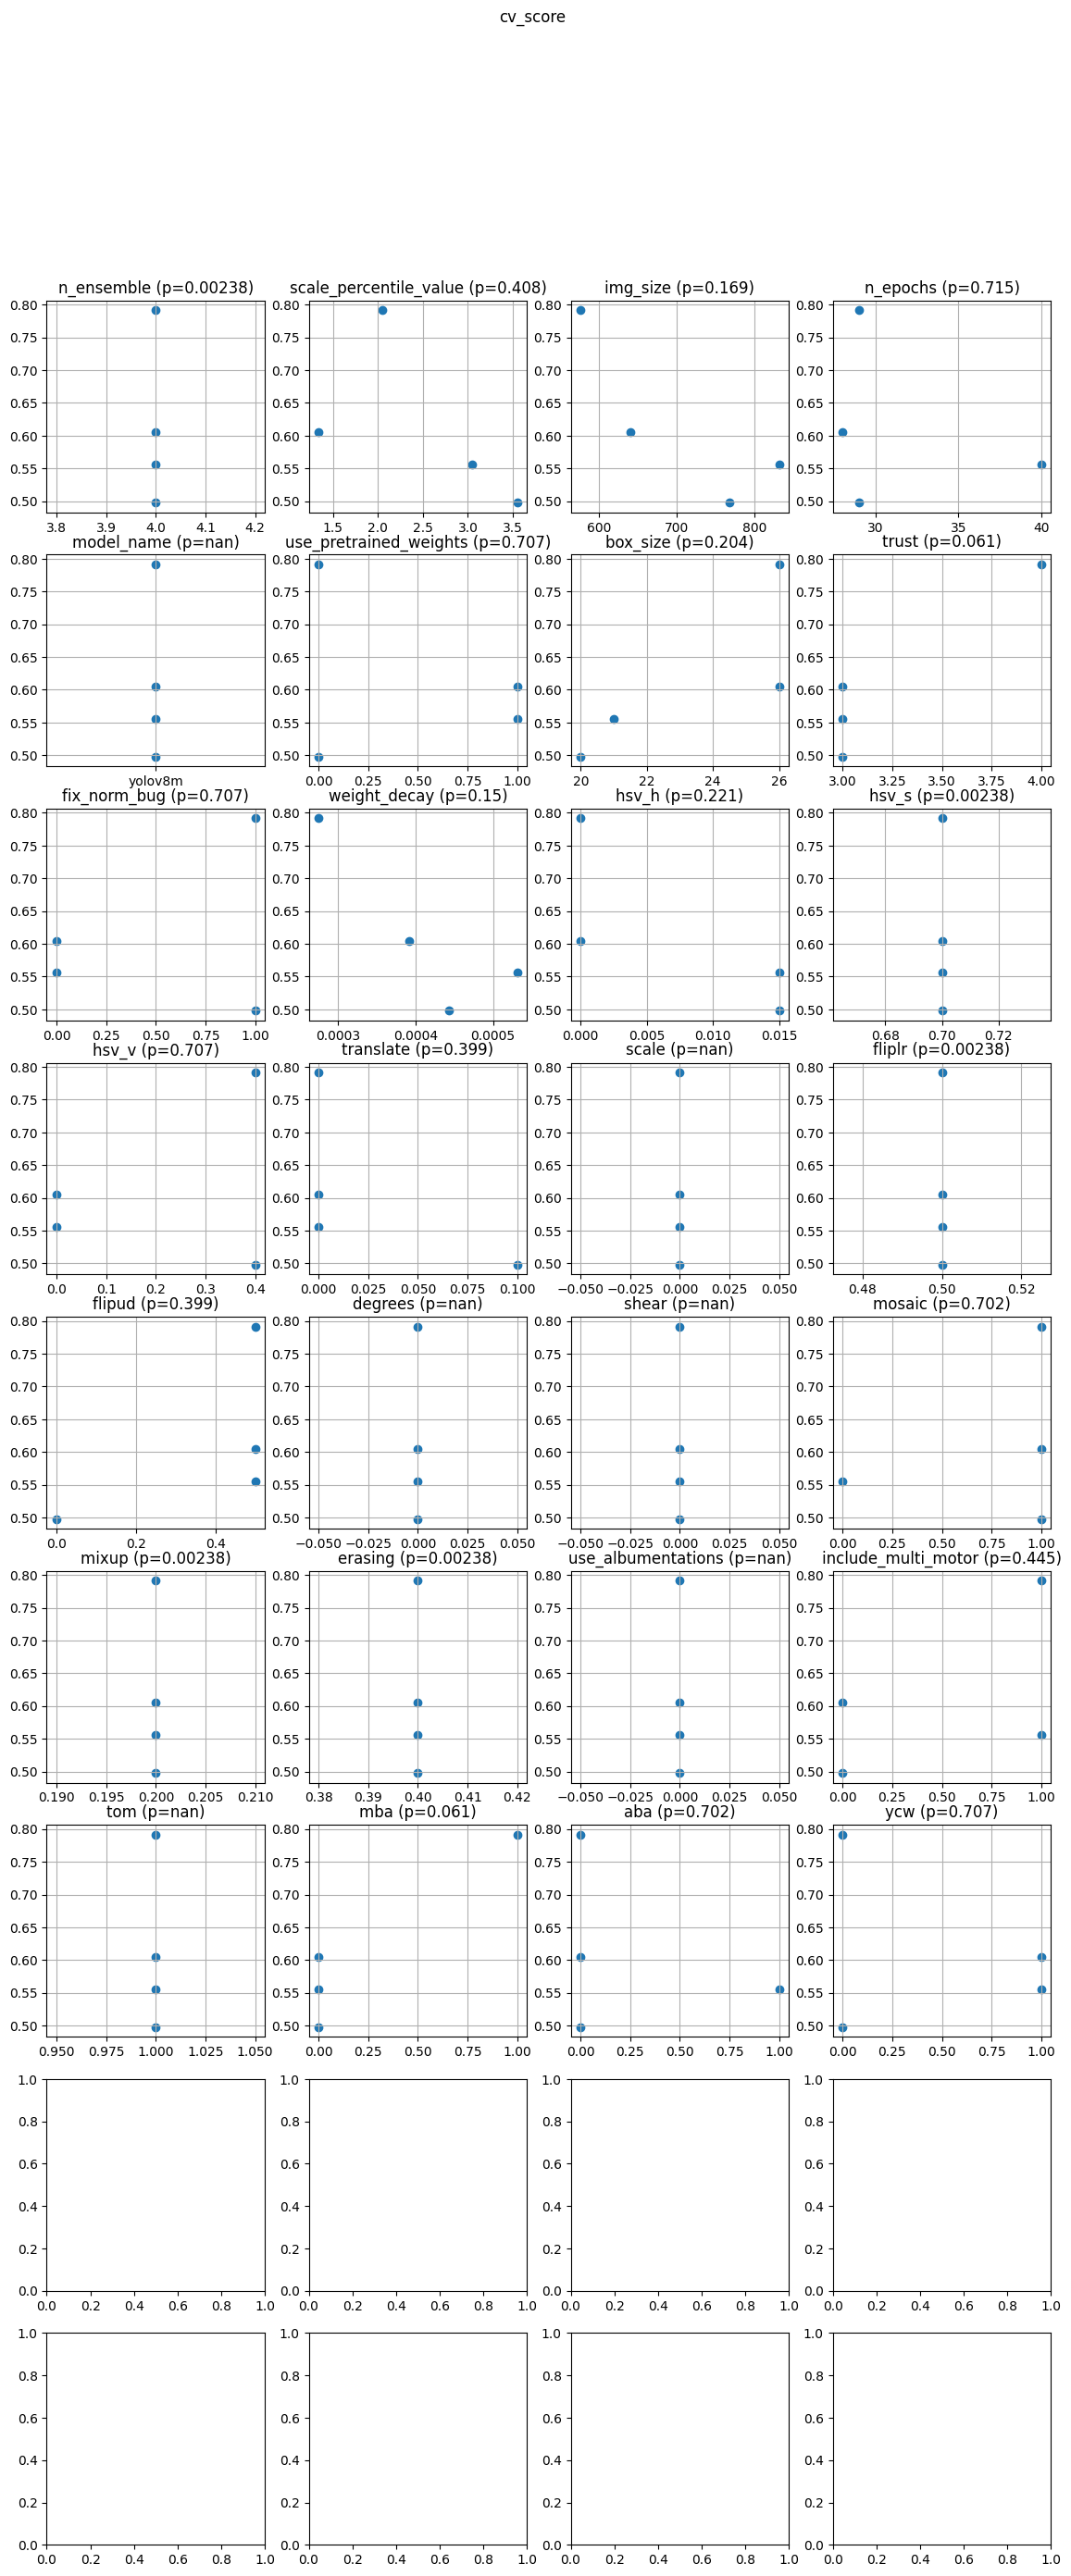

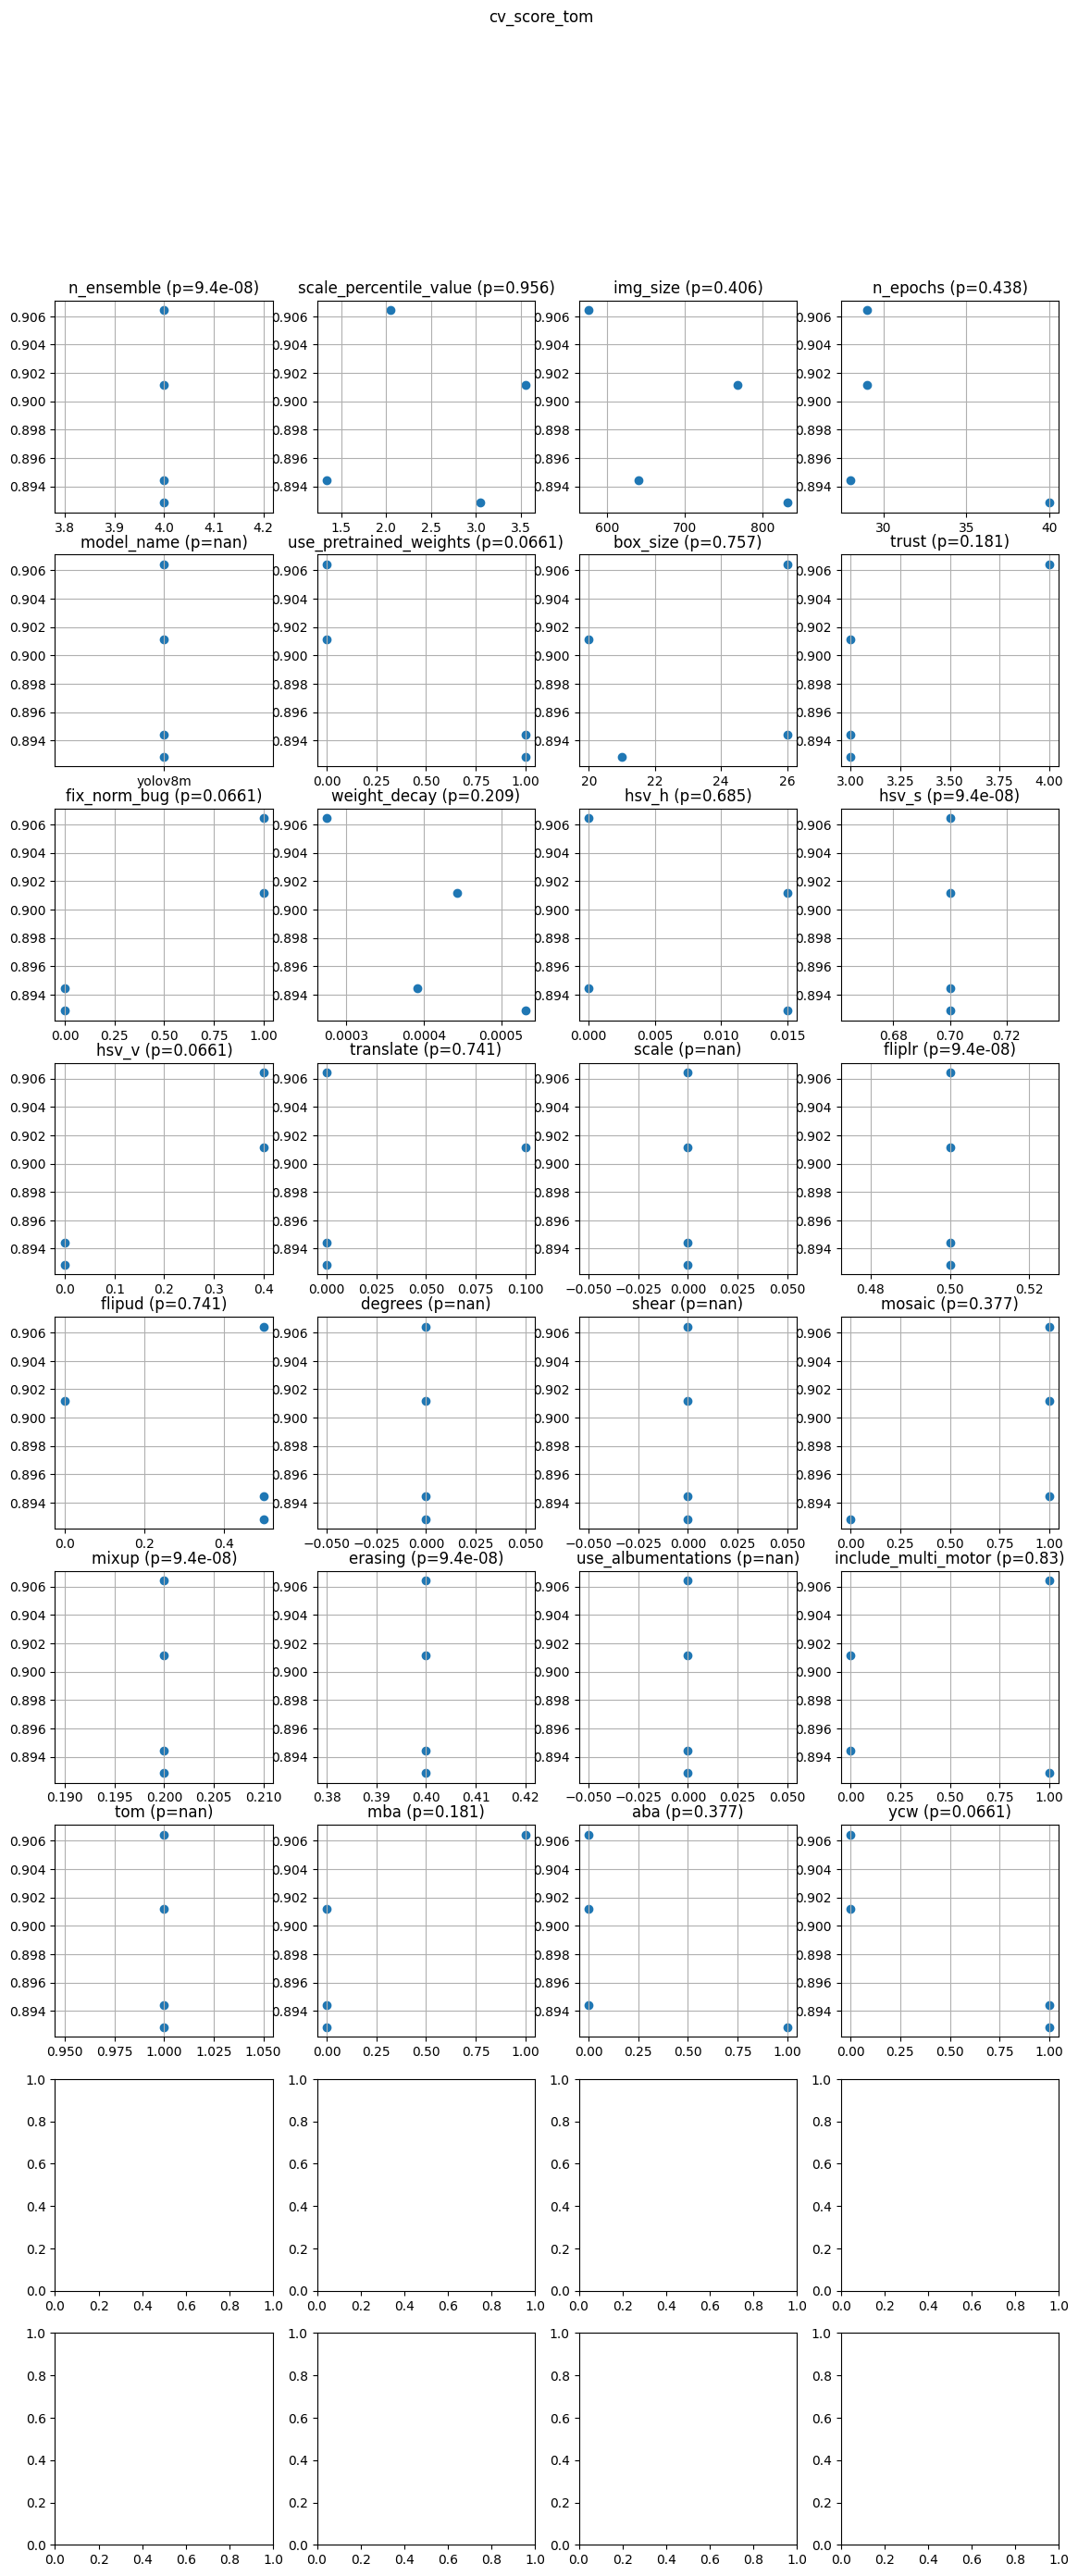

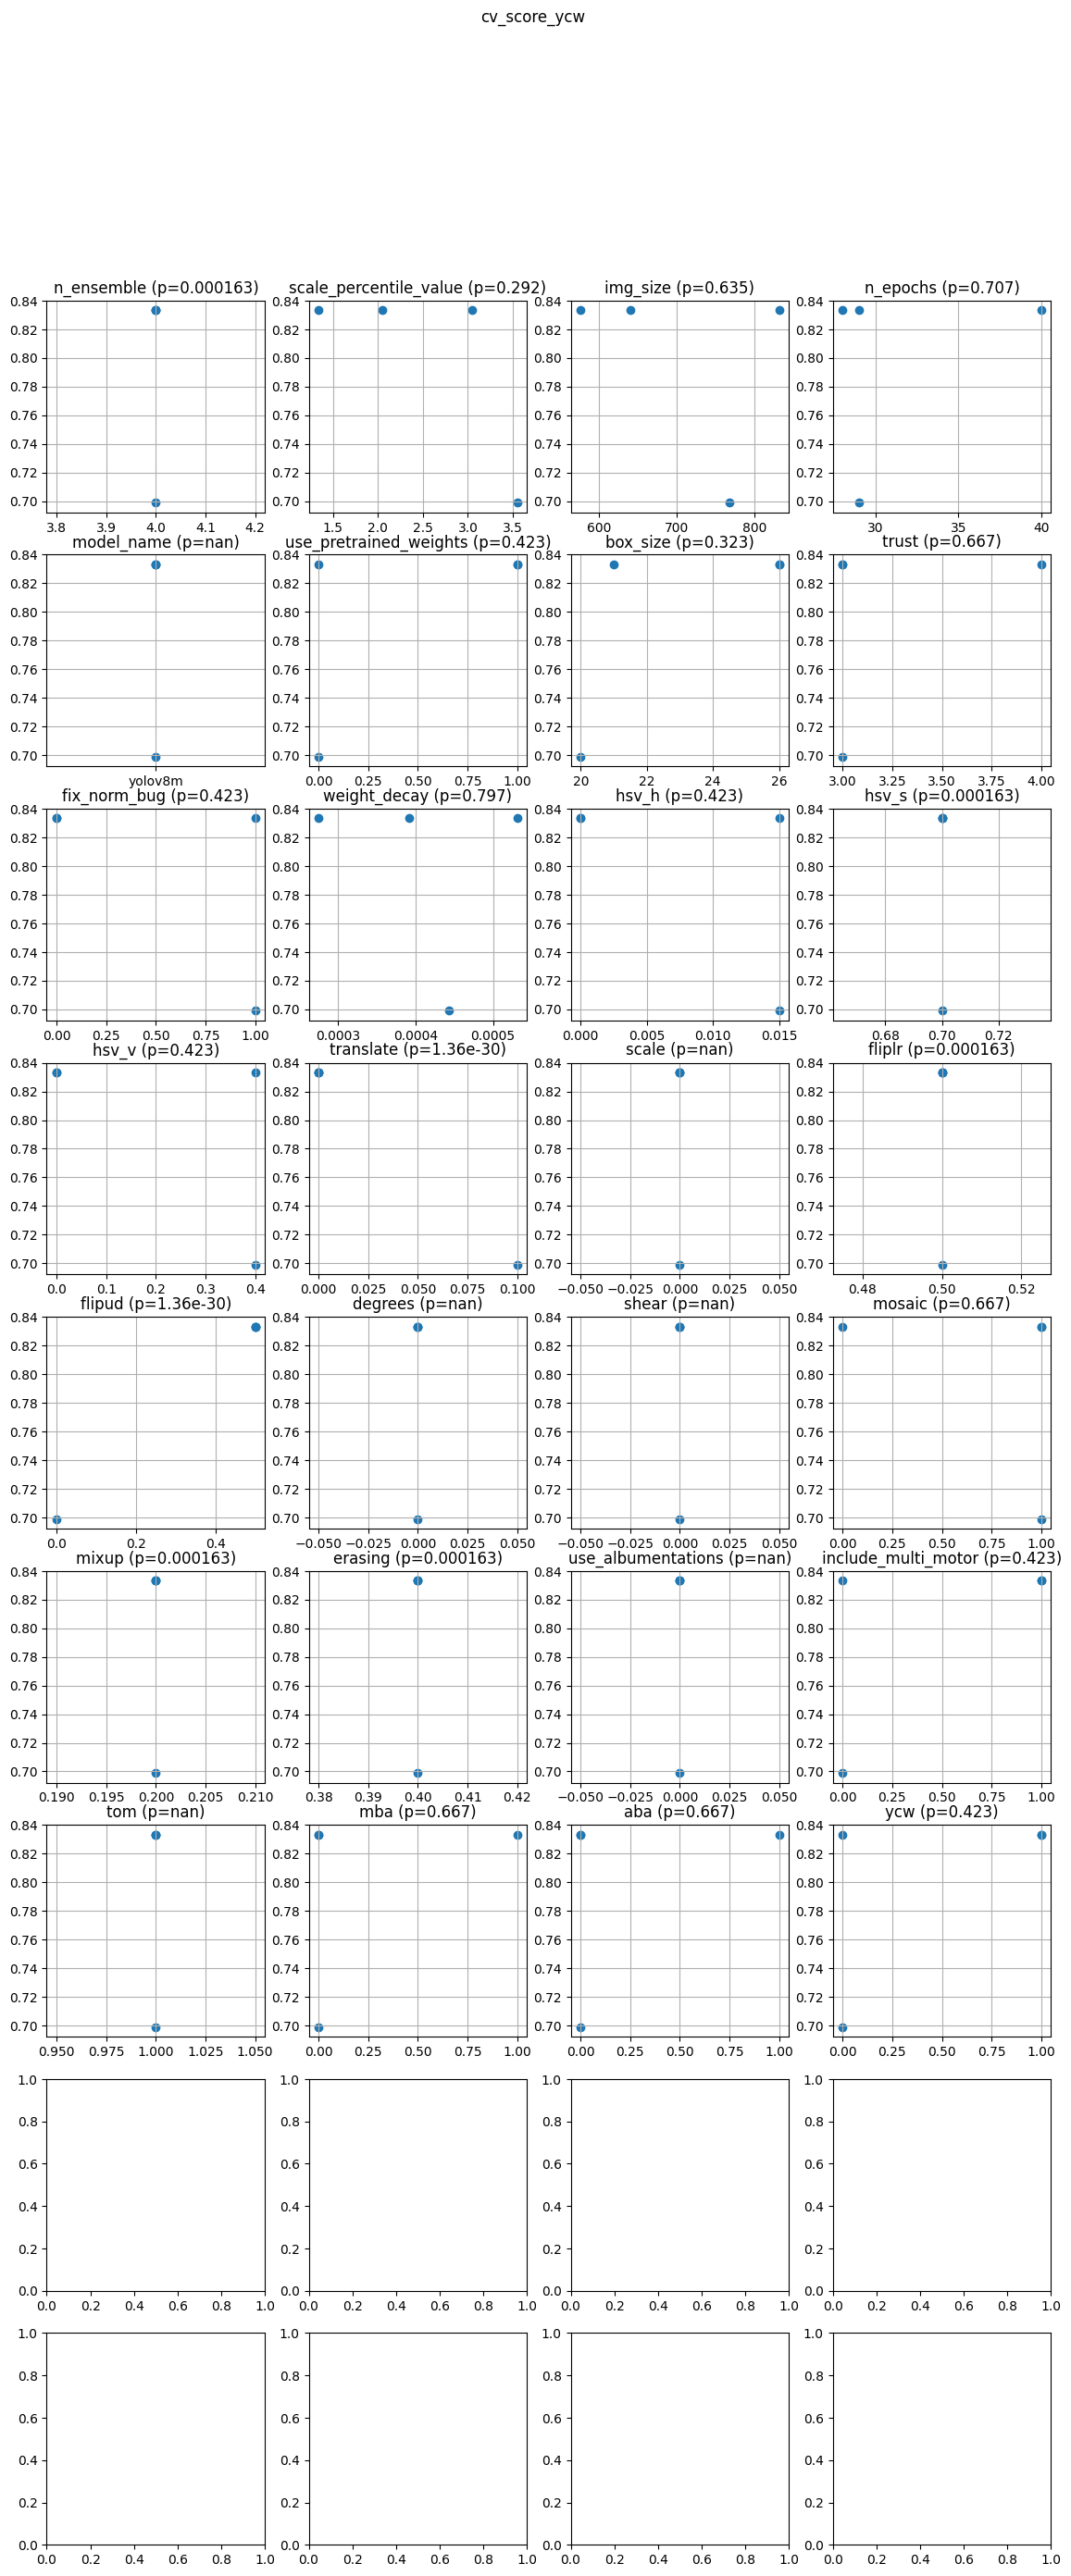

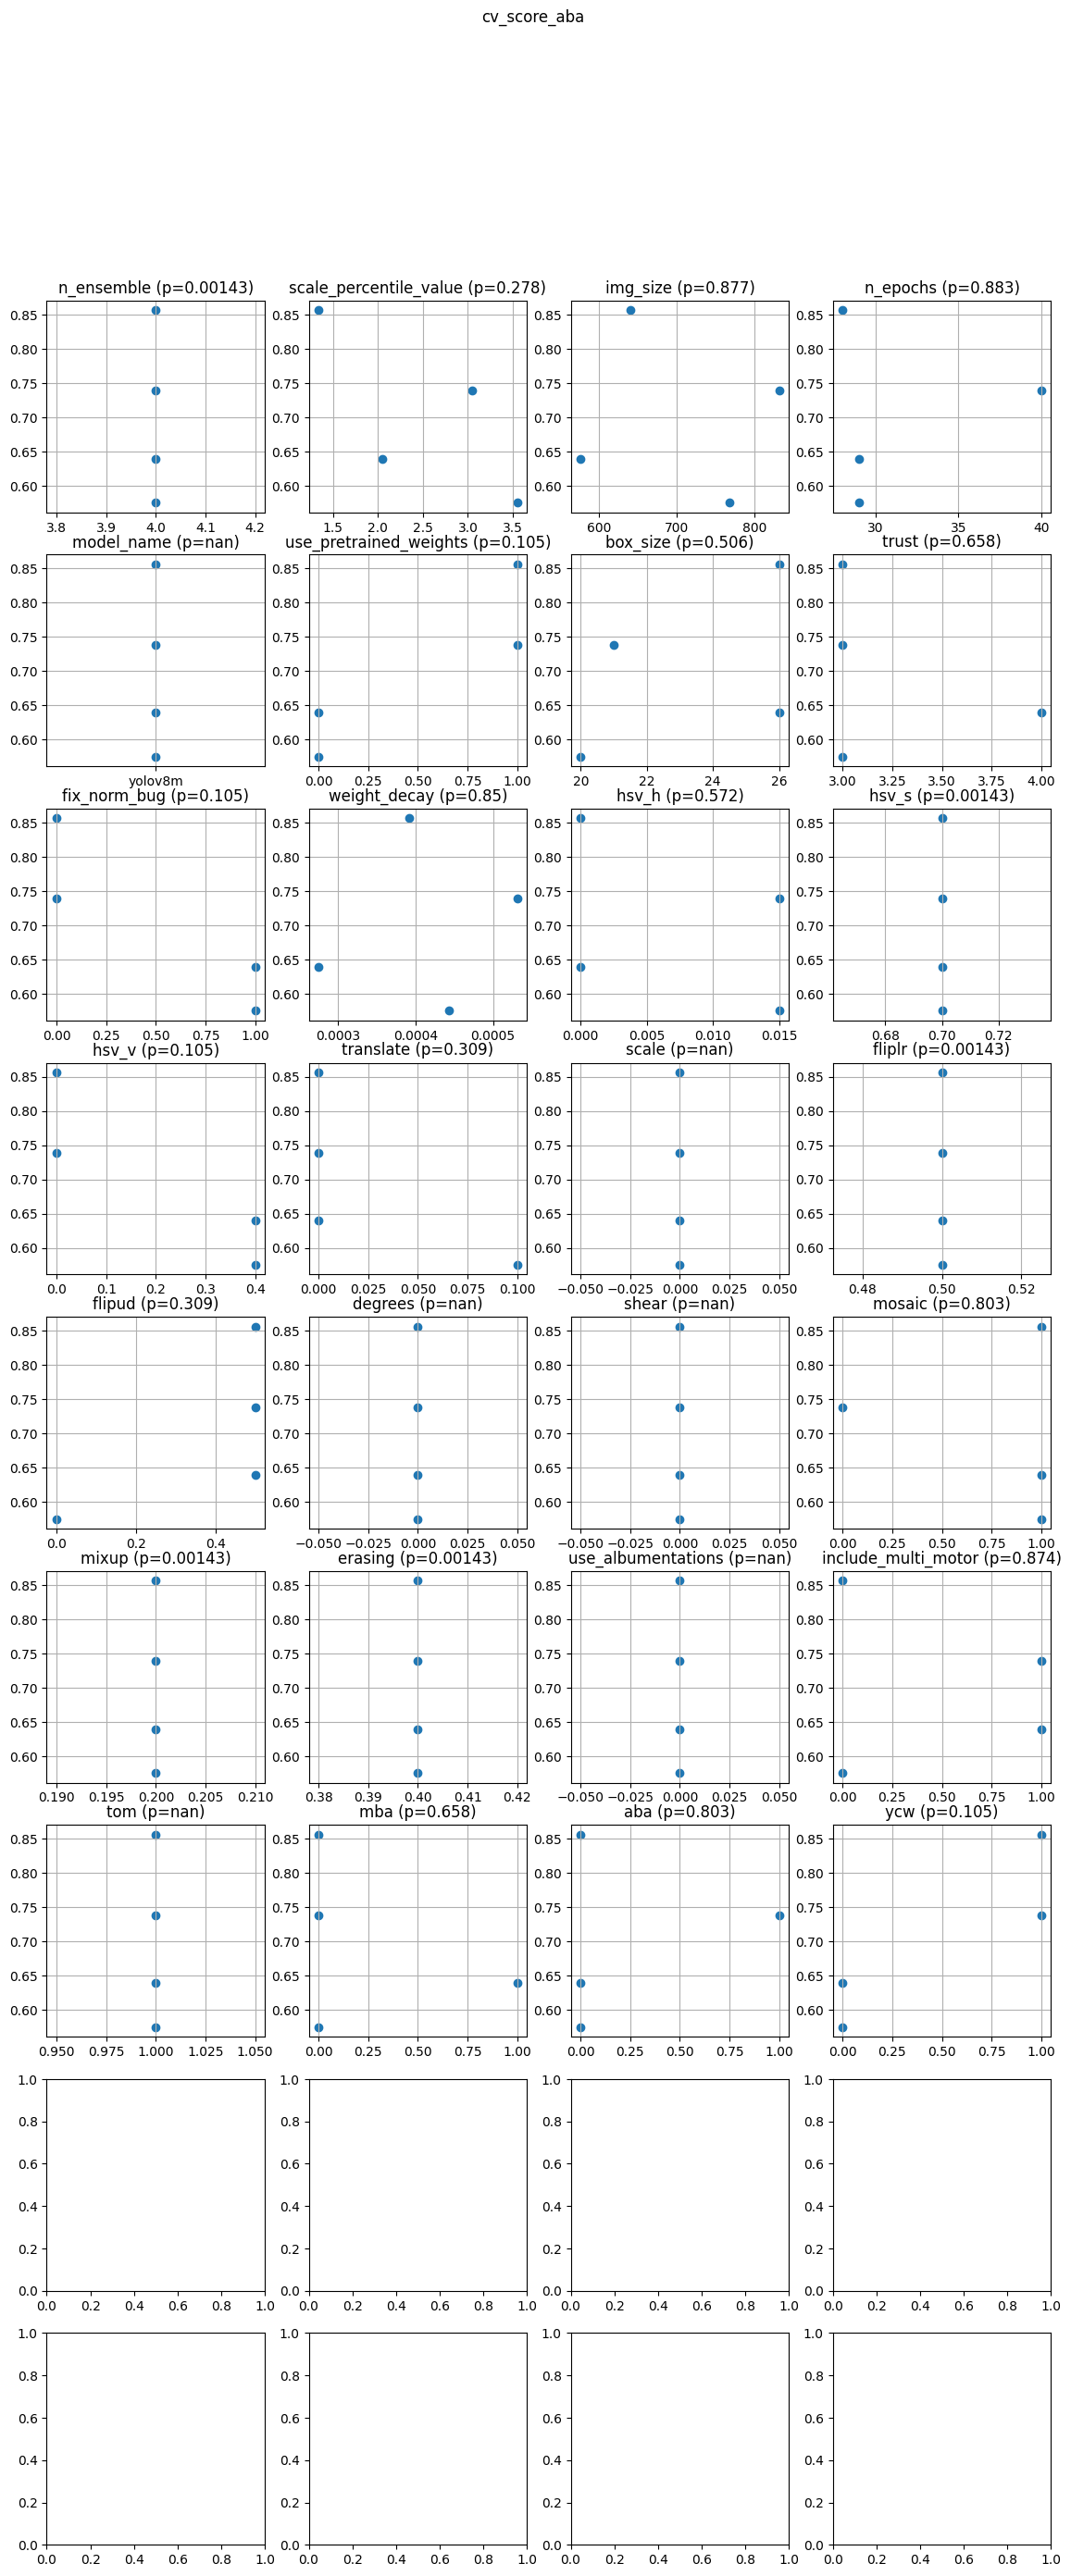

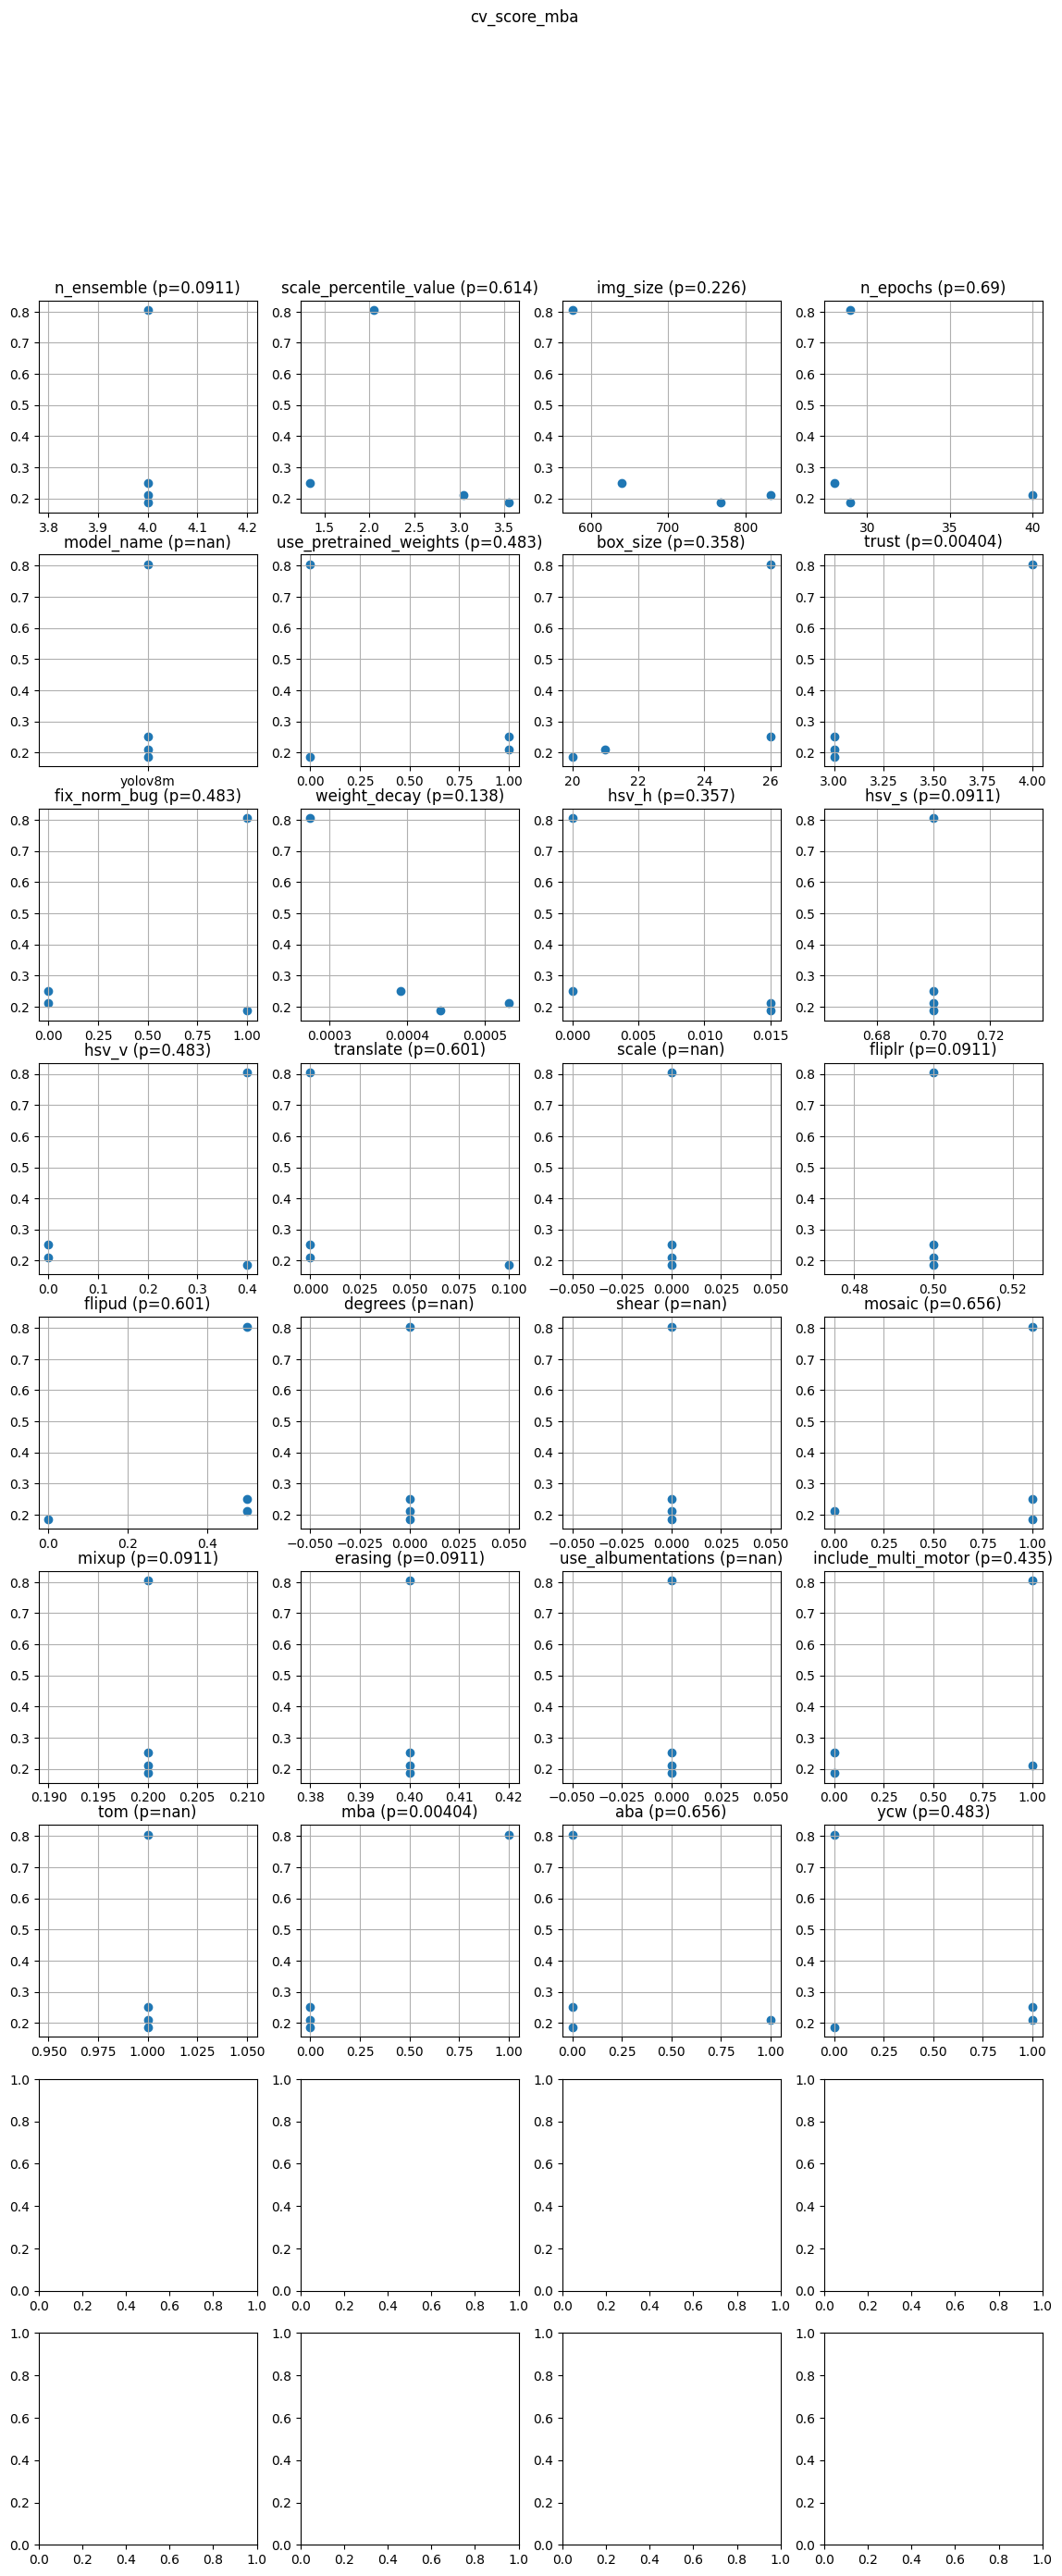

In [9]:
to_plot = copy.deepcopy(p).columns.to_list()[2:-9]
main = np.logical_not(p['use_missing_value'])
#main = p['tom']
for x_val in ['cv_score', 'cv_score_tom', 'cv_score_ycw', 'cv_score_aba', 'cv_score_mba']:
    plt.figure()
    plt.scatter(p[x_val][main], p['k_score'][main])
    plt.grid(True)
    plt.xlabel(x_val)
    plt.ylabel('Kaggle score')
ncols = 4
nrows = len(to_plot)//ncols+2
for y_val in p.columns[-6:][[5,0,1,2,3,4]].to_list():
    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(14,14/ncols*nrows))
    plt.suptitle(y_val)
    for idx,d in enumerate(to_plot):
        row = idx // ncols
        col = idx % ncols
        ax = axes[row, col]
        plt.sca(ax)        
        plt.xlabel('')
        plt.ylabel('')
        plt.grid(True)
        plt.scatter(p[d][main], p[y_val][main])
        plt.scatter(p[d][np.logical_not(main)], p[y_val][np.logical_not(main)])
       
        # fit
        pp = copy.deepcopy(p)
        if not pd.api.types.is_numeric_dtype(pp[d]) or pd.api.types.is_bool_dtype(pp[d]):
            pp[d] = pp[d].astype('category').cat.codes
        X = pp[[d]][main]
        X['intercept'] = 1.
        y = p[y_val][main]
        to_keep = np.logical_not(np.isnan(y))
        X = X[to_keep]; y=y[to_keep];
        model = sm.OLS(y,X)
        results=model.fit()
        p_val = results.pvalues[d]
        plt.title(f'{d} (p={p_val:.3})')
        
        # if d == 'mask_sizes0':
        #     x_vals = [m.mask_sizes[model.particles_to_do[0]][0] for m in model_list]
        # elif d == 'mask_sizes1':
        #     x_vals = [m.mask_sizes[model.particles_to_do[0]][1] for m in model_list]
        # elif d == 'mask_sizes2':
        #     x_vals = [m.mask_sizes[model.particles_to_do[0]][2] for m in model_list]
        # else:
        #     x_vals = [getattr(m, d)[model.particles_to_do[0]] for m in model_list]
        # if len(np.unique(x_vals))<8:
        #     #pass
        #     violin_plot(x_vals,score_vals)
        # else:
        #     plt.scatter(x_vals, score_vals)